# INFORMAÇÕES IMPORTANTES:

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

## SEI LA SABE

In [19]:
import pandas as pd
import tensorflow as tf
import numpy as np


#-----------------------------------------------------------
#Lê os dados do arquivo CSV.
#-----------------------------------------------------------
data = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/BPAC_30m_2019.csv') 
data.head()
#print(df)
#df.info()

,time,open,high,low,close,Volume
0,2019-01-02T10:00:00-02:00,5.9125,5.9375,5.9125,5.9300,7600
1,2019-01-02T10:30:00-02:00,5.9300,5.9700,5.9200,5.9525,46800
2,2019-01-02T11:00:00-02:00,5.9575,5.9925,5.9400,5.9800,52800
3,2019-01-02T11:30:00-02:00,5.9875,6.0050,5.9825,5.9900,57200
4,2019-01-02T12:00:00-02:00,5.9950,6.0350,5.9900,6.0175,60400


In [20]:
#-----------------------------------------------------------
#Escolhe a coluna de série temporal única de interesse.
#-----------------------------------------------------------
symbol = "close"

data = pd.DataFrame(data[symbol])
data.head()


,close
0,5.9300
1,5.9525
2,5.9800
3,5.9900
4,6.0175


In [22]:
#-----------------------------------------------------------
#Renomeia a única coluna para price
#-----------------------------------------------------------

data.rename(columns={symbol: 'price'}, inplace=True)

data.head()

,price
0,5.9300
1,5.9525
2,5.9800
3,5.9900
4,6.0175


In [27]:
#-----------------------------------------------------------
# Calcula o log de retorno e define a direção como uma coluna binária.
#-----------------------------------------------------------

#Log Retorno
data['return'] = np.log(data['price']/data['price'].shift(1))

#Coluna binária
data['direction'] = np.where(data['return'] > 0, 1, 0)
#data.head()

display(data)

,price,return,direction
0,5.9300,NaN,0
1,5.9525,0.003787,1
2,5.9800,0.004609,1
3,5.9900,0.001671,1
4,6.0175,0.004580,1
...,...,...,...
3912,18.8975,0.002649,1
3913,18.9000,0.000132,1
3914,18.9350,0.001850,1
3915,18.9175,-0.000925,0


In [29]:

lags = 4

cols = []
#-----------------------------------------------------------
# Cria os Lagged Data
#-----------------------------------------------------------
for lag in range(1, lags + 1):
     col = f'lag_{lag}'
#-----------------------------------------------------------
# Cria novas colunas DataFrame com os retornos de log deslocados pelo respectivo número de atrasos
#-----------------------------------------------------------
     data[col] = data['return'].shift(lag)
     cols.append(col)
#-----------------------------------------------------------
# Exclui as linhas que contêm valores NaN.
#-----------------------------------------------------------
data.dropna(inplace=True)

In [31]:
#-----------------------------------------------------------
# Imprime as cinco linhas finais indicando os “padrões” emergentes nas quatro colunas de recursos
#-----------------------------------------------------------

#data.round(4).tail() 
display(data)

,price,return,direction,lag_1,lag_2,lag_3,lag_4
5,6.0850,0.011155,1,0.004580,0.001671,0.004609,0.003787
6,6.1425,0.009405,1,0.011155,0.004580,0.001671,0.004609
7,6.1350,-0.001222,0,0.009405,0.011155,0.004580,0.001671
8,6.1625,0.004472,1,-0.001222,0.009405,0.011155,0.004580
9,6.1700,0.001216,1,0.004472,-0.001222,0.009405,0.011155
...,...,...,...,...,...,...,...
3912,18.8975,0.002649,1,-0.001326,-0.001324,-0.001718,-0.003428
3913,18.9000,0.000132,1,0.002649,-0.001326,-0.001324,-0.001718
3914,18.9350,0.001850,1,0.000132,0.002649,-0.001326,-0.001324
3915,18.9175,-0.000925,0,0.001850,0.000132,0.002649,-0.001326


In [37]:
#-----------------------------------------------------------
# Importa o pacote TensorFlow.
#-----------------------------------------------------------
import tensorflow as tf
#-----------------------------------------------------------
# Importa o objeto de modelo necessário do Keras
#-----------------------------------------------------------
from keras.models import Sequential
#-----------------------------------------------------------
# Importa o objeto de camada relevante do Keras
#-----------------------------------------------------------
from keras.layers import Dense
#-----------------------------------------------------------
# Importa a LSTM
#-----------------------------------------------------------
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam, RMSprop

optimizer = Adam(learning_rate=0.0001)

In [93]:
#-----------------------------------------------------------
# Um modelo Sequencial é instanciado.
#-----------------------------------------------------------
model=Sequential()

#-----------------------------------------------------------
# As camadas ocultas e a camada de saída são definidas.
#-----------------------------------------------------------
model.add(LSTM(100,activation='relu',input_shape=(lags,1),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(1))

#-----------------------------------------------------------
# Compila o objeto de modelo Sequencial para classificação.
#-----------------------------------------------------------
model.compile(optimizer=optimizer,
 loss='mse',
metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 4, 100)            40800     
_________________________________________________________________
lstm_23 (LSTM)               (None, 4, 50)             30200     
_________________________________________________________________
lstm_24 (LSTM)               (None, 10)                2440      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 73,451
Trainable params: 73,451
Non-trainable params: 0
_________________________________________________________________


In [94]:
#-----------------------------------------------------------
# Define a data limite entre os dados de treinamento e teste.
#-----------------------------------------------------------
cutoff = 2740

#-----------------------------------------------------------
# Define os conjuntos de dados de treinamento e teste.
#-----------------------------------------------------------
training_data = data[data.index < cutoff].copy()
test_data = data[data.index >= cutoff].copy()

display(training_data)
display(test_data)

,price,return,direction,lag_1,lag_2,lag_3,lag_4
5,6.0850,0.011155,1,0.004580,0.001671,0.004609,0.003787
6,6.1425,0.009405,1,0.011155,0.004580,0.001671,0.004609
7,6.1350,-0.001222,0,0.009405,0.011155,0.004580,0.001671
8,6.1625,0.004472,1,-0.001222,0.009405,0.011155,0.004580
9,6.1700,0.001216,1,0.004472,-0.001222,0.009405,0.011155
...,...,...,...,...,...,...,...
2735,13.4300,-0.003902,0,0.007071,-0.000187,0.000373,-0.001120
2736,13.7450,0.023184,1,-0.003902,0.007071,-0.000187,0.000373
2737,13.7750,0.002180,1,0.023184,-0.003902,0.007071,-0.000187
2738,13.8250,0.003623,1,0.002180,0.023184,-0.003902,0.007071


,price,return,direction,lag_1,lag_2,lag_3,lag_4
2740,13.8300,-0.002167,0,0.002528,0.003623,0.002180,0.023184
2741,13.8050,-0.001809,0,-0.002167,0.002528,0.003623,0.002180
2742,13.8350,0.002171,1,-0.001809,-0.002167,0.002528,0.003623
2743,13.7025,-0.009623,0,0.002171,-0.001809,-0.002167,0.002528
2744,13.7500,0.003461,1,-0.009623,0.002171,-0.001809,-0.002167
...,...,...,...,...,...,...,...
3912,18.8975,0.002649,1,-0.001326,-0.001324,-0.001718,-0.003428
3913,18.9000,0.000132,1,0.002649,-0.001326,-0.001324,-0.001718
3914,18.9350,0.001850,1,0.000132,0.002649,-0.001326,-0.001324
3915,18.9175,-0.000925,0,0.001850,0.000132,0.002649,-0.001326


In [115]:
#-----------------------------------------------------------
# Normaliza os dados de recursos por normalização gaussiana.
#-----------------------------------------------------------
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data_ = (test_data - mu) / std 

In [118]:
#training_data[cols]

In [109]:
%%time
#-----------------------------------------------------------
# Ajusta o modelo ao conjunto de dados de treinamento.
#-----------------------------------------------------------
model.fit(training_data[cols], # Lags
    training_data['direction'], # 0 e 1
    epochs=100, verbose=False, batch_size=32,
    validation_split=0.2, shuffle=False)

CPU times: user 1min 41s, sys: 7.67 s, total: 1min 49s
Wall time: 43.8 s


In [110]:
res = pd.DataFrame(model.history.history)
res.head()

,loss,accuracy,val_loss,val_accuracy
0,0.249840,0.515996,0.249520,0.517367
1,0.249840,0.515996,0.249520,0.521024
2,0.249840,0.515996,0.249520,0.522852
3,0.249840,0.515996,0.249520,0.522852
4,0.249839,0.515996,0.249519,0.522852


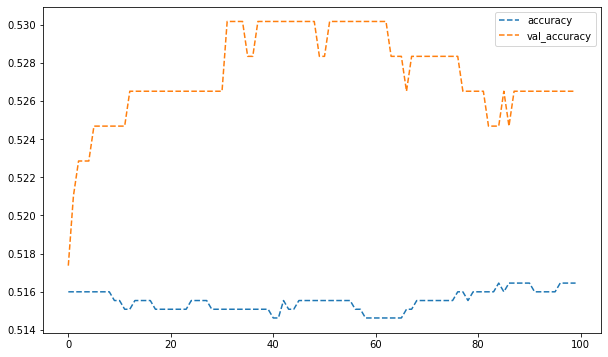

In [112]:
#-----------------------------------------------------------
# Precisão do classificador LSTM nos dados de treinamento e validação por etapa de treinamento
#-----------------------------------------------------------

# Segundo esse link, o melhor é ajustar os valores de accuracy, val_accuracy 
# para que os valores estejam o mais próximos possiveis.
# https://stackoverflow.com/questions/51335133/keras-how-come-accuracy-is-higher-than-val-acc

res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [119]:
model.evaluate(training_data[cols], training_data['direction'])

86/86 [==============================] - 0s 3ms/step - loss: 0.2496 - accuracy: 0.5199


[0.2496388703584671, 0.5199268460273743]